# 3. Adaptivní 2D histogramy

In [1]:
import pandas as pd
import os
import numpy as np
import physt
from physt import h1, h2, h3
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
# Pandas magic box (nebudu prozrazovat)
def read_data(path, clean=True):
    data = pd.read_csv(path, delimiter=";", decimal=",", header=None, names=["cas", "misto", "teplota"])
    data["cas"] = pd.to_datetime(data.cas)
    data["rok"] = data.cas.dt.year
    if clean:
        data = data[(data.rok >= 2014 ) & (data.rok <= 2015)]
    data["id"] = data.misto.str.extract("(?<=\\\\)(.*)(?=\\\\)").str.lower()
    data["mesic"] = data.cas.dt.month
    data["hodina"] = data.cas.dt.hour
    data["den_v_roce"] = data.cas.dt.dayofyear
    data["den_v_tydnu"] = (data.cas.dt.dayofweek - 1) % 7 + 1
    data["sekunda_dne"] = data.cas.dt.hour * 3600 + data.cas.dt.minute * 60 + data.cas.dt.second
    del data["misto"]
    if clean:
        data = data[(data.teplota < 50) & (data.teplota > -40)]
    return data

In [3]:
# Jenom se podíváme na data, jak vypadají
read_data("data/Veveří.zip").head()

/home/honza/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,cas,teplota,rok,id,mesic,hodina,den_v_roce,den_v_tydnu,sekunda_dne
14964,2015-11-26 08:13:47,3.5,2015,ma23astr,11,8,330,3,29627
14965,2015-11-26 08:30:12,3.5,2015,ma23astr,11,8,330,3,30612
14966,2015-11-26 09:00:13,3.8,2015,ma23astr,11,9,330,3,32413
14967,2015-11-26 09:30:16,4.1,2015,ma23astr,11,9,330,3,34216
14968,2015-11-26 10:00:00,4.3,2015,ma23astr,11,10,330,3,36000


In [4]:
# Vytvoříme 3D histogramy a uložíme si je vedle
def create_histograms():
    import glob
    soubory = glob.glob("data/*.zip")
    
    for path in soubory:
        jmeno = path.split("/")[1].split(".")[0]
        data = read_data(path)
        histogram = h3([data.mesic, data.hodina, data.teplota],
                       ("integer", "fixed_width", "fixed_width"),
                       bin_width=(1, 1, 1),
                       adaptive=True,
                       name=jmeno)
        histogram.to_json(path = os.path.join("../data", jmeno + ".json"), indent=2)
        print(jmeno + " uložen/a/o.")

# create_histograms()

In [5]:
from physt.io import load_json
import glob
histogramy = { 
    soubor.split("/")[-1].split(".")[0] : load_json(soubor)
    for soubor in glob.glob("../data/*json") 
}

In [6]:
histogramy

{'Bohunice': HistogramND(bins=(12, 24, 61), total=1469486, dtype=int64),
 'Bystrc': HistogramND(bins=(12, 24, 90), total=2477044, dtype=int64),
 'Chrlice': HistogramND(bins=(12, 24, 59), total=182639, dtype=int64),
 'Juliánov': HistogramND(bins=(12, 24, 85), total=1195691, dtype=int64),
 'Jundrov': HistogramND(bins=(12, 24, 62), total=350555, dtype=int64),
 'Kamenný Vrch': HistogramND(bins=(12, 24, 87), total=2004745, dtype=int64),
 'Kohoutovice': HistogramND(bins=(12, 24, 85), total=1392147, dtype=int64),
 'Komárov': HistogramND(bins=(12, 24, 56), total=104617, dtype=int64),
 'Komín': HistogramND(bins=(12, 24, 88), total=1528427, dtype=int64),
 'Královo Pole': HistogramND(bins=(12, 24, 90), total=1137679, dtype=int64),
 'Lesná': HistogramND(bins=(12, 24, 87), total=2250981, dtype=int64),
 'Líšeň': HistogramND(bins=(12, 24, 90), total=7442230, dtype=int64),
 'Medlánky': HistogramND(bins=(12, 24, 67), total=747426, dtype=int64),
 'Město': HistogramND(bins=(12, 24, 84), total=338547, dty

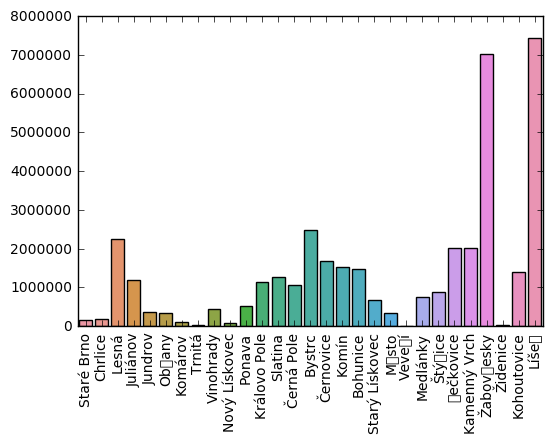

In [7]:
# Pro ilustraci si zobrazíme, kolik dat je odkud
import seaborn.apionly as sns
ax = sns.barplot([h.name for h in histogramy.values()], [h.total for h in histogramy.values()])
ax.set_xticklabels([h.name for h in histogramy.values()], rotation=90);

##  Aritmetika

In [8]:
histogramy["Komín"] + histogramy["Černá Pole"]

HistogramND(bins=(12, 24, 90), total=2588061, dtype=int64)

In [9]:
histogramy["Černá Pole"] - histogramy["Komín"]   # Co je tohle???

/home/honza/opt/anaconda3/lib/python3.5/site-packages/physt-0.3.27-py3.5.egg/physt/histogram_base.py:824: UserWarning: Subtracting histograms is considered to be a bad idea.
  warnings.warn("Subtracting histograms is considered to be a bad idea.")


HistogramND(bins=(12, 24, 90), total=-468793, dtype=int64)

In [10]:
histogramy["Komín"] / 78

HistogramND(bins=(12, 24, 88), total=19595.217948717946, dtype=float64)

Sečteme všechny!

In [11]:
brno = sum(histogramy.values())
brno.name = "Celé Brno"
brno

HistogramND(bins=(12, 24, 90), total=38801293, dtype=int64)

## Projekce

Histogram1D(bins=(12,), total=38801293, dtype=int64)

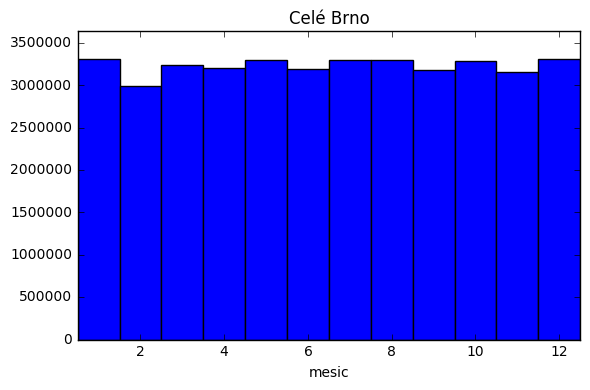

In [12]:
mesice = brno.projection("mesic")
mesice.plot()
mesice

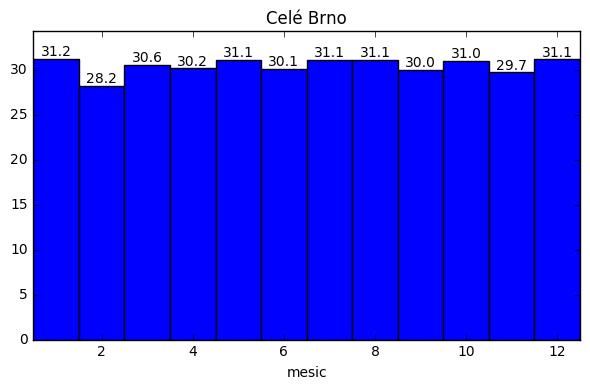

In [13]:
# Nezměříme délku měsíců?
(mesice.normalize() * 365.25).plot(show_values=True, value_format=".1f");

### Dvourozměrná projekce

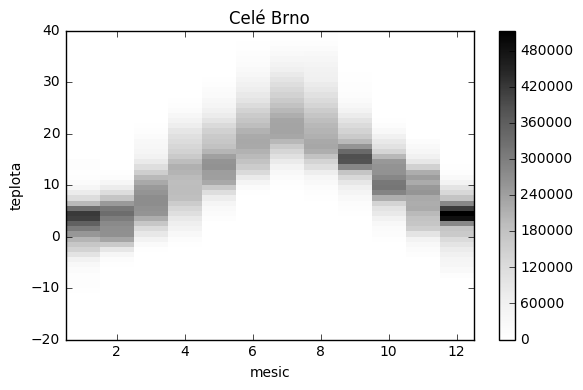

In [14]:
H = brno.projection("mesic", "teplota")
H.plot(lw=0, ylim=(-20, 40), show_colorbar=True)


Histogram2D(bins=(24, 90), total=38801293, dtype=int64)

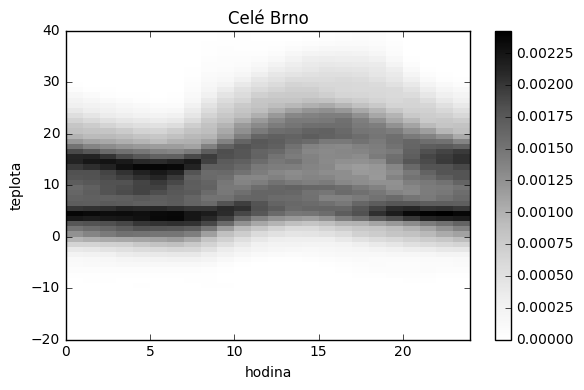

In [15]:
# Normalizujeme
H = brno.projection("hodina", "teplota")
H.normalize().plot(lw=0, ylim=(-20, 40), show_colorbar=True)
H


## Částečná normalizace

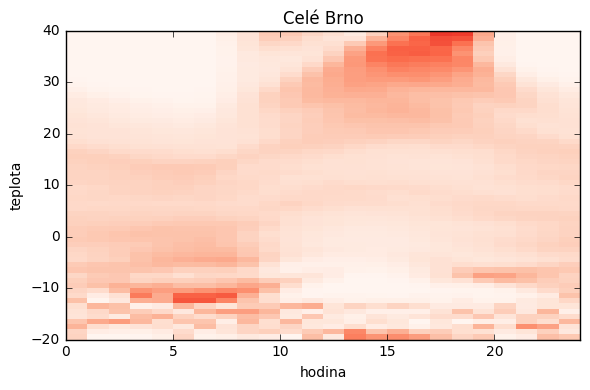

In [16]:
H.partial_normalize("hodina").plot(lw=0, ylim=(-20, 40), show_colorbar=False, cmap="Reds")

## Výběr části

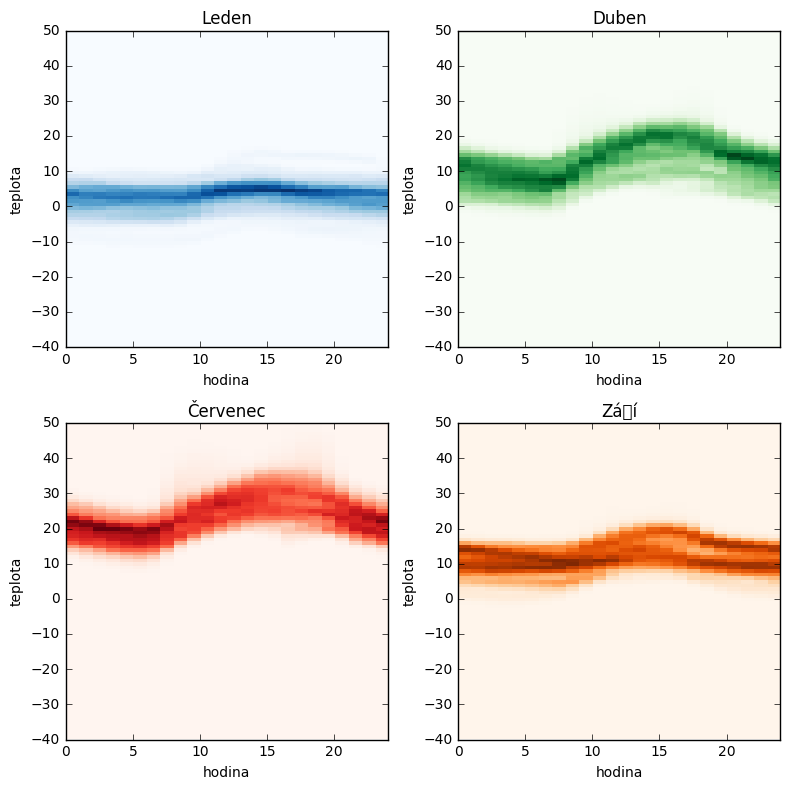

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
brno.select("mesic", 0).plot("image", cmap="Blues",ax=axes[0][0], show_colorbar=False)
brno.select("mesic", 3).plot("image", cmap="Greens",ax=axes[0][1], show_colorbar=False)
brno.select("mesic", 6).plot("image", cmap="Reds",ax=axes[1][0], show_colorbar=False)
brno.select("mesic", 9).plot("image", cmap="Oranges",ax=axes[1][1], show_colorbar=False)
axes[0][0].set_title("Leden")
axes[0][1].set_title("Duben")
axes[1][0].set_title("Červenec")
axes[1][1].set_title("Září")

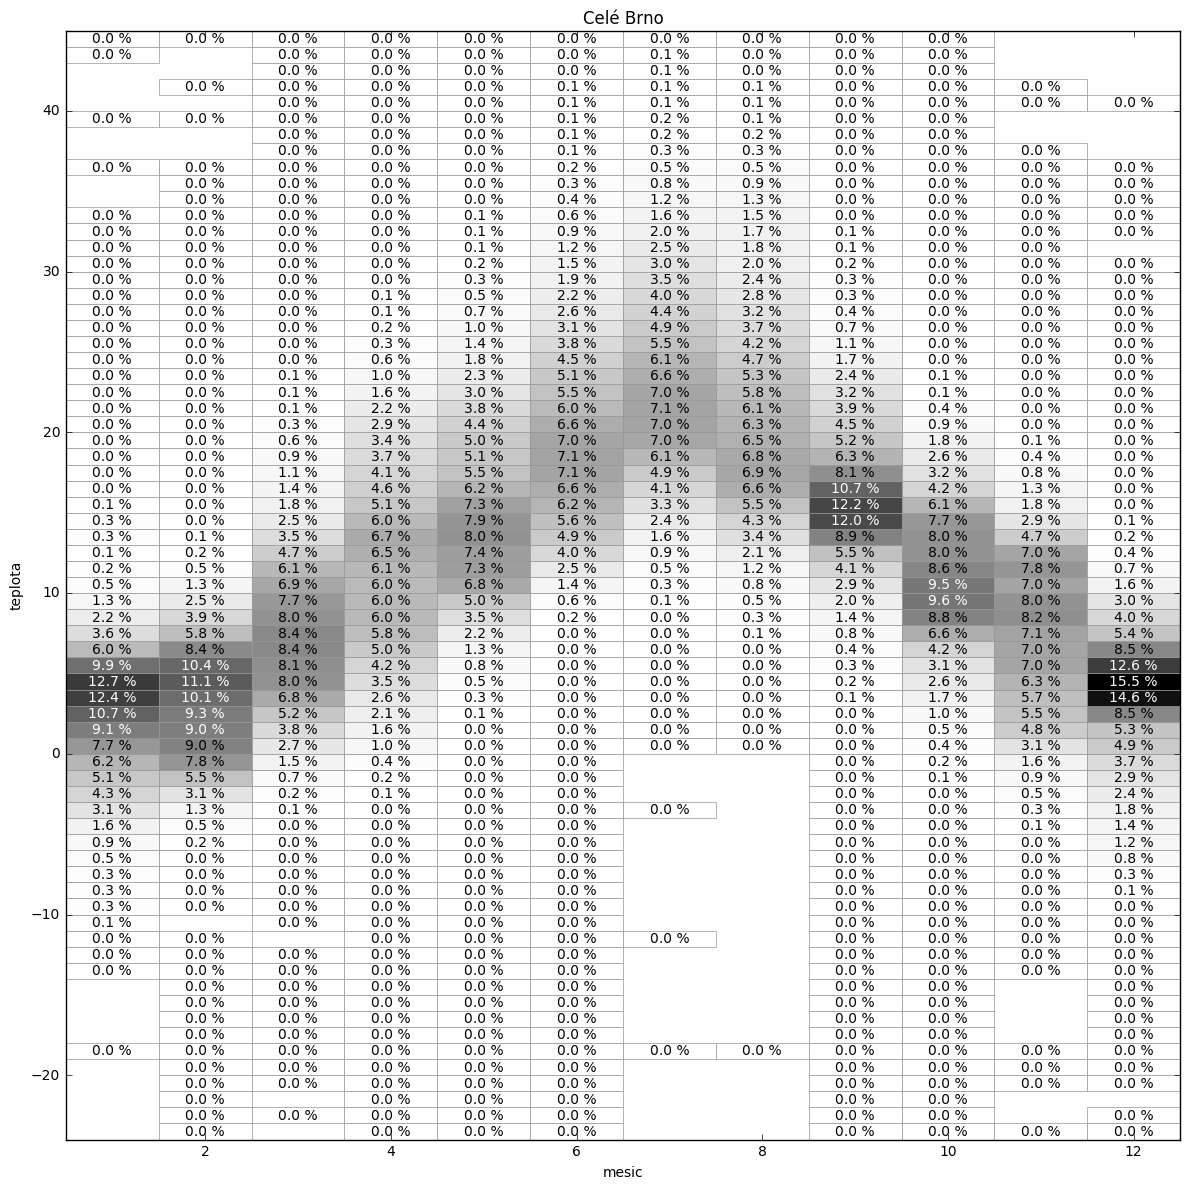

In [18]:
brno.projection("mesic", "teplota").partial_normalize("teplota").plot(ylim=(-24, 45), show_values=True, show_zero=False, figsize=(12, 12), value_format=lambda x: "{0:.1f} %".format(x*100), show_colorbar=0)

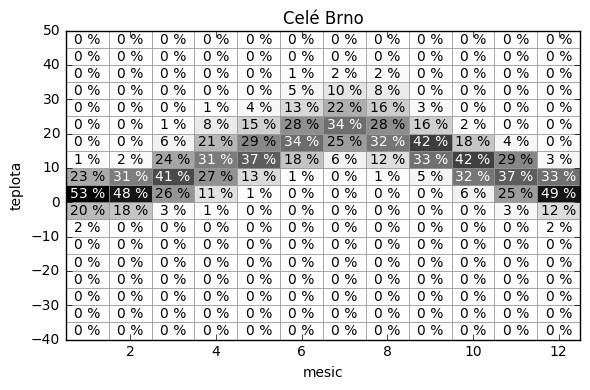

In [19]:
brno.projection("mesic", "teplota").merge_bins(5, axis=1).partial_normalize("teplota").plot(show_values=True, value_format=lambda x: "{0} %".format(int(np.round(x*100))), show_colorbar=0)